In [1]:
%matplotlib inline

In [2]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import FIG_DIR, DATA_DIR


In [3]:
figure_data_file = os.path.join(FIG_DIR, 'fig_4_data.csv')

if not os.path.exists(figure_data_file):
    df = pd.read_csv(os.path.join(DATA_DIR, 'MFP.csv'))

    meal_ref = {'breakfast': 0, 'lunch': 1, 'dinner': 2, 'snack': 3}
    df['meal_index'] = df['meal'].apply(lambda s: meal_ref[s])

    def enlist(lst):
        """ Enlist a mixture of list and str, return as original order"""
        res = []
        for i in lst:
            if isinstance(i, list) or isinstance(i, tuple):
                res.extend(i)
            else:
                if i == i:
                    res.append(i)
        return res

    def user_repeated_cnt_time_bounded(d, window_size=7):
        user_repeated = defaultdict(int)
        for user, t in sorted(d.keys()):
            curr_food = d[(user, t)]
            prev_food = enlist([d.get((user, n), [])
                                for n in np.arange(t - (window_size - 1), t, 1)])
            user_repeated[user] += len(set(curr_food) & set(prev_food))
        return user_repeated

    data = df.groupby(['uid', 'meal_index'])['days'].apply(len).to_frame().reset_index()
    data = data.pivot(index='uid', columns='meal_index')['days'].reset_index()

    for i in range(4):
        dic = df[df['meal_index'] == i].groupby(['uid', 'days'])['food_id'].apply(list).to_dict()
        user_repeated_cnt = user_repeated_cnt_time_bounded(dic)
        data['repeat_cnt_' + str(i)] = data['uid'].apply(lambda s: user_repeated_cnt[s])
        data['perc_' + str(i)] = data['repeat_cnt_' + str(i)] / data[i]

    rev_meal_ref = {v: k for k, v in meal_ref.items()}

    cols = ['perc_' + str(i) for i in range(4)]
    rename_cols = {'perc_' + str(i): 'perc_' + rev_meal_ref[i] for i in range(4)}
    data[cols].rename(str, columns=rename_cols).describe()
    cols = ['uid', 'perc_0', 'perc_1', 'perc_2', 'perc_3']

    data[cols].to_csv(figure_data_file, index=False)


In [4]:
def plot_CDF(data):
    """input is series"""
    data = data.dropna()
    data = data.value_counts().sort_index().cumsum() / data.shape[0]
    data.index.names = ['prob']
    return data


In [5]:
def plot_fig4(data):
    figure_name = os.path.join(FIG_DIR, 'paper_fig_4.png')

    # set background param
    plt.rc('pdf', fonttype=42)
    sns.set(style="ticks")
    sns.set_context("paper", font_scale=1.5)
    fig, ax = plt.subplots(figsize=(6, 3))

    # plot
    meal_ref = {'breakfast': 0, 'lunch': 1, 'dinner': 2, 'snack': 3}
    rev_meal_ref = {v: k for k, v in meal_ref.items()}
    rename_cols = {'perc_' + str(i): ' '.join(['m =', rev_meal_ref[i]]) for i in range(4)}
    cols = [' '.join(['m =', m]) for m in ['breakfast', 'lunch', 'dinner', 'snack']]
    df = data.rename(str, columns=rename_cols)
    data_lst = [plot_CDF(df[col]) for col in cols]
    sns.lineplot(data=data_lst)

    # grid & spline
    ax.grid(ls="dotted")
    sns.despine(offset=10)

    # ticks & legend
    xlabel = "% Repeat consumption for meal $m$, $R^{m, k}_i$"
    ylabel = "Pr($R^{m, k}_i \leq x $)"
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(left=0, right=1)
    plt.ylim(bottom=0, top=1)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
    plt.gca().set_xticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_xticks()])
    plt.legend(loc='lower right')

    # save figure
    fig.tight_layout()
    plt.savefig(figure_name, dpi=200, transparent=False, bbox_inches='tight', pad_inches=0.0)
    plt.show()


In [6]:
data = pd.read_csv(figure_data_file)


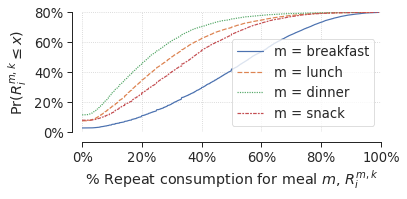

In [7]:
plot_fig4(data)
